# Performance on randomly labeled training data

In [1]:
import pandas as pd
import numpy as np

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression

In [2]:
%matplotlib inline

In [3]:
np.random.seed(3452346134)

## Read training data

In [4]:
orig_train = pd.read_csv("../data/clean_train.tsv", sep='\t')

In [5]:
orig_train.shape

(138639, 5)

In [6]:
orig_train.head(3)

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100054,0,22434,989
1,DB00104,ORPHA:100054,0,3845,989
2,DB00115,ORPHA:100054,0,54459,989


## Read holdout data

In [7]:
holdoutd = pd.read_csv("../data/clean_holdout.tsv", sep='\t')

In [8]:
holdoutd.head(3)

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100050,0,22434,14962
1,DB00104,ORPHA:100050,0,3845,14962
2,DB00121,ORPHA:100050,0,41945,14962


## Read node map

In [9]:
mapping = (pd
    .read_csv("../data/node_map.tsv", sep='\t')
    [["uid", ":ID"]]
    .rename(columns={":ID": "node_id"})
)

In [10]:
mapping.head(3)

,uid,node_id
0,0,9247
1,1,GO:0021987
2,2,GO:0032414


## Pipeline

In [11]:
def randomize_train(orig_train, K):
    """Randomly assign true/false labels to the original
    training data chemical-disease pairs.
    
    Keeps ratios of true/false labels the same as the original
    training data. Subsamples negatives.
    """
    
    labels = list(orig_train["category"]) # true labels
    np.random.shuffle(labels)
    
    chems = list(orig_train["chemical_id"])
    np.random.shuffle(chems)
    
    dises = list(orig_train["disease_id"])
    np.random.shuffle(dises)
    
    data = (pd
        .DataFrame(
            list(zip(chems, dises, labels)),
            columns=["chemical_id", "disease_id", "label"]
        )
        .merge(
            mapping, how="inner", left_on="chemical_id", right_on="node_id"
        )
        .drop("node_id", axis=1)
        .rename(columns={"uid": "chemical_uid"})
        .merge(
            mapping, how="inner", left_on="disease_id", right_on="node_id"
        )
        .drop("node_id", axis=1)
        .rename(columns={"uid": "disease_uid"})
        .drop_duplicates()
    )
    
    # subsample negatives
    posdata = data.query("label == 1")
    
    return (posdata
        .append(
            data.query("label == 0").sample(K * len(posdata))
        )
        .reset_index(drop=True)
    )

In [12]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

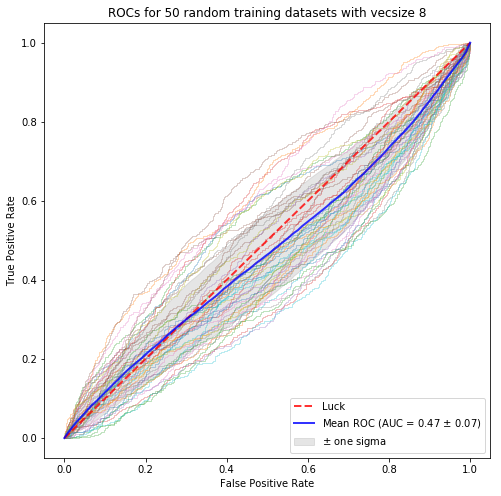

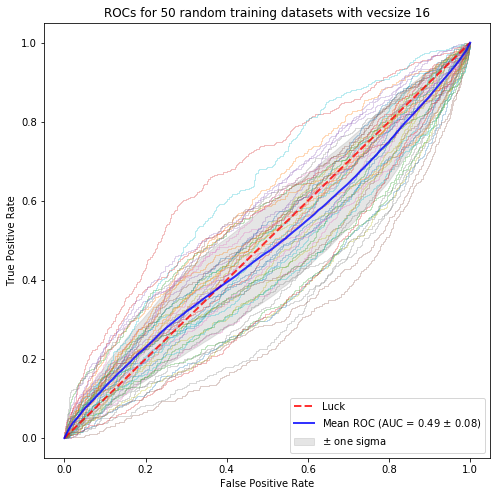

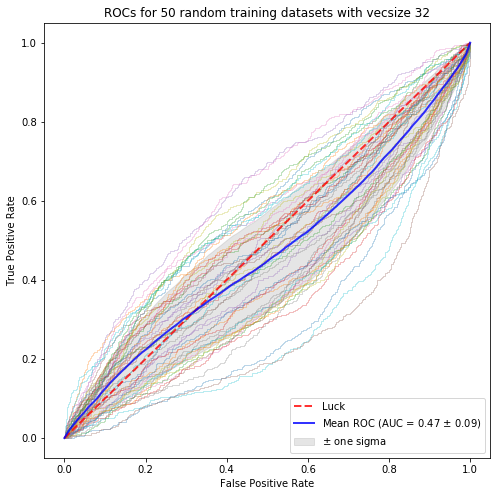

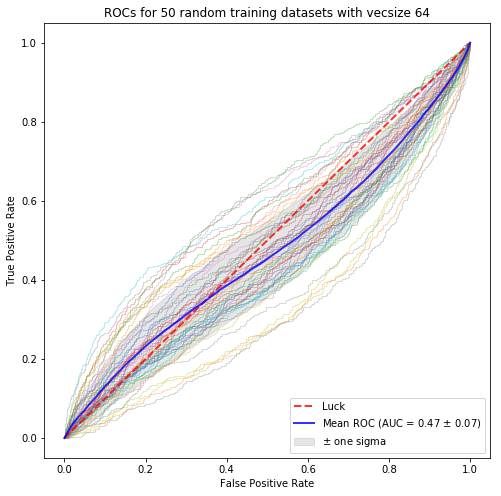

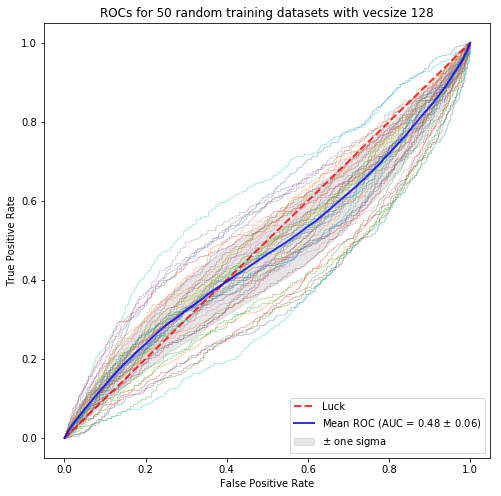

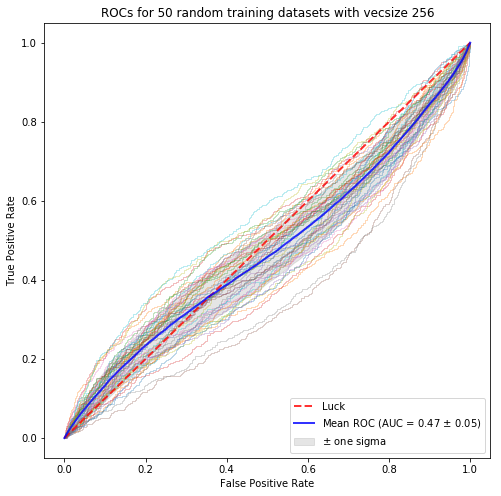

In [13]:
iterations = 50
sizes = list(2**i for i in range(3, 9))

for vecsize in sizes:
    plt.figure(figsize=(8, 8))

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    features = pd.read_csv(
        "../embeddings/normal_{}.txt".format(vecsize),
        sep=" ", skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )
    
    for i in range(iterations):
        traindata = randomize_train(orig_train, 5)
        
        tmp = convolv_features(traindata, features, vecsize)
        
        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["label"])
        
        # test on holdout
        test = convolv_features(
            holdoutd.drop("category", axis=1),
            features, vecsize
        )

        # add in predictions
        ans = test.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        fpr, tpr, thresh = roc_curve(
            holdoutd["category"], ans["predval"]
        )
        
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0
        auc_val = auc(fpr, tpr)
        aucs.append(auc_val)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3)
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(
        mean_fpr, mean_tpr, color='b',
        label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr, tprs_lower, tprs_upper, color='grey',
        alpha=0.2, label="$\pm$ one sigma"
    )
     
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(
        "ROCs for {} random training datasets with vecsize {}".format(
            iterations, vecsize
        )
    )

    plt.legend(loc="lower right")
    plt.show()